### Loading Packages

In [1]:
# for loading/processing the images  
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array

from keras.applications.vgg16 import preprocess_input 

# models 
from keras.applications.vgg16 import VGG16 
from keras.models import Model

# clustering and dimension reduction
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# for everything else
import os
import numpy as np
import matplotlib.pyplot as plt
from random import randint
import pandas as pd
import pickle

### Loading image files

In [2]:
path = r"C:\Users\Ray\OneDrive\Desktop\Capstone Project\GAN_images\Crests_Raw\crest_images"
# change the working directory to the path where the images are located
os.chdir(path)

# this list holds all the image filename
crests = []

# creates a ScandirIterator aliased as files
with os.scandir(path) as files:
  # loops through each file in the directory
    for file in files:
        crests.append(file.name)
            
# view the first 10 crest entries
print(crests[:10])

['0015f809daf7fe6b1d1e00404bd3c43d--family-crest-coat-of-arms2.jpg', '0024fedfe39dffdd1c8a532853a5b1d3--family-crest-coat-of-arms3.jpg', '00728a1b68457298887e39ecb0c8c6e1--beauregard-family-crest2.jpg', '016317f308ffa3abfb0ad5174db2dbef--family-crest-coat-of-arms2.jpg', '01a9f156e8148a50f171834ada235982--family-crest-coat-of-arms2.jpg', '01b516480e5872172f38c8753365d8c7--family-crest-coat-of-arms2.jpg', '0453b920f7f3a07d53a70082b4696242--family-crest-coat-of-arms2.jpg', '045e7d4b96945b6f6d58de3426eccab0--family-crest-coat-of-arms.jpg', '04bdedc2d2daac3e62c542e377af9758--family-crest-coat-of-arms2.jpg', '0721d5ac0f125002aebefd019557e3ba--family-crest-coat-of-arms2.jpg']


### Preprocessing the image files

In [3]:

# load the image as a 224x224 array
img = load_img(crests[0], target_size=(224,224))
# convert from 'PIL.Image.Image' to numpy array
img = np.array(img)
reshaped_img = img.reshape(1,224,224,3)
x = preprocess_input(reshaped_img)

### Loading the model and writing function to extract features

In [4]:
model = VGG16()
model = Model(inputs = model.inputs, outputs = model.layers[-2].output)

def extract_features(file, model):
    # load the image as a 224x224 array
    img = load_img(file, target_size=(224,224))
    # convert from 'PIL.Image.Image' to numpy array
    img = np.array(img) 
    # reshape the data for the model reshape(num_of_samples, dim 1, dim 2, channels)
    reshaped_img = img.reshape(1,224,224,3) 
    # prepare image for model
    imgx = preprocess_input(reshaped_img)
    # get the feature vector
    features = model.predict(imgx, use_multiprocessing=True)
    return features

Now we can use this feature_extraction function to extract the features from all of the images and store the features in a dictionary with filename as the keys

In [5]:
data = {}
p = r"C:\Users\Ray\OneDrive\Desktop\Capstone Project\GAN_images\Crest_Features\crest_features.pkl"


# lop through each image in the dataset
for crest in crests:
    # try to extract the features and update the dictionary
    try:
        feat = extract_features(crest,model)
        data[crest] = feat
    # if something fails, save the extracted features as a pickle file (optional)
    except:
        with open(p,'wb') as file:
            pickle.dump(data,file)

#get a list of the filenames
filenames = np.array(list(data.keys()))

# get a list of just the features
feat = np.array(list(data.values()))
feat.shape
(210, 1, 4096)

# reshape so that there are 210 samples of 4096 vectors
feat = feat.reshape(-1,4096)
feat.shape
(210, 4096)


# get the unique labels (from the flower_labels.csv)
#df = pd.read_csv('flower_labels.csv')
#label = df['label'].tolist()
#unique_labels = list(set(label))

1/1 [==============================] - 0s 153ms/step


1/1 [==============================] - 0s 159ms/step


1/1 [==============================] - 0s 156ms/step


1/1 [==============================] - 0s 164ms/step


1/1 [==============================] - 0s 156ms/step


1/1 [==============================] - 0s 159ms/step


1/1 [==============================] - 0s 156ms/step


1/1 [==============================] - 0s 153ms/step


1/1 [==============================] - 0s 157ms/step


(210, 4096)

### Dimensionality Reduction
Reducing feature vector from 4000+ to 100 using principal component analysis 

In [8]:
pca = PCA(n_components=100, random_state=22)
pca.fit(feat)
x = pca.transform(feat)

print(f"Components before PCA: {feat.shape[1]}")
print(f"Components after PCA: {pca.n_components}")

Components before PCA: 4096
Components after PCA: 100


### Deciding the right number of clusters
We want to use an elbow chart to determine the right value of k (number of clusters) where we start  to see diminishing returns on the sum of squared distance as we increase cluster count.

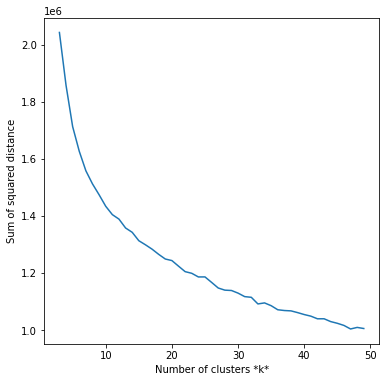

In [9]:
# this is just incase you want to see which value for k might be the best 
sse = []
list_k = list(range(3, 50))

for k in list_k:
    km = KMeans(n_clusters=k, random_state=22)
    km.fit(x)
    
    sse.append(km.inertia_)

# Plot sse against k
plt.figure(figsize=(6, 6))
plt.plot(list_k, sse)
plt.xlabel(r'Number of clusters *k*')
plt.ylabel('Sum of squared distance');

In this case, it would appear a good number of clusters to use would be 10

### Running our clustering

In [10]:
kmeans = KMeans(n_clusters=10, random_state=22)
kmeans.fit(x)

KMeans(n_clusters=10, random_state=22)

### Visualising the images in the clusters

In [11]:
#First create dict for cluster and images within
# holds the cluster id and the images { id: [images] }
groups = {}
for file, cluster in zip(filenames,kmeans.labels_):
    if cluster not in groups.keys():
        groups[cluster] = []
        groups[cluster].append(file)
    else:
        groups[cluster].append(file)

#create function to view images in given cluster
def view_cluster(cluster):
    plt.figure(figsize = (25,25));
    # gets the list of filenames for a cluster
    files = groups[cluster]
    # plot each image in the cluster
    for index, file in enumerate(files):
        plt.subplot(10,10,index+1);
        img = load_img(file)
        img = np.array(img)
        plt.imshow(img)
        plt.axis('off')

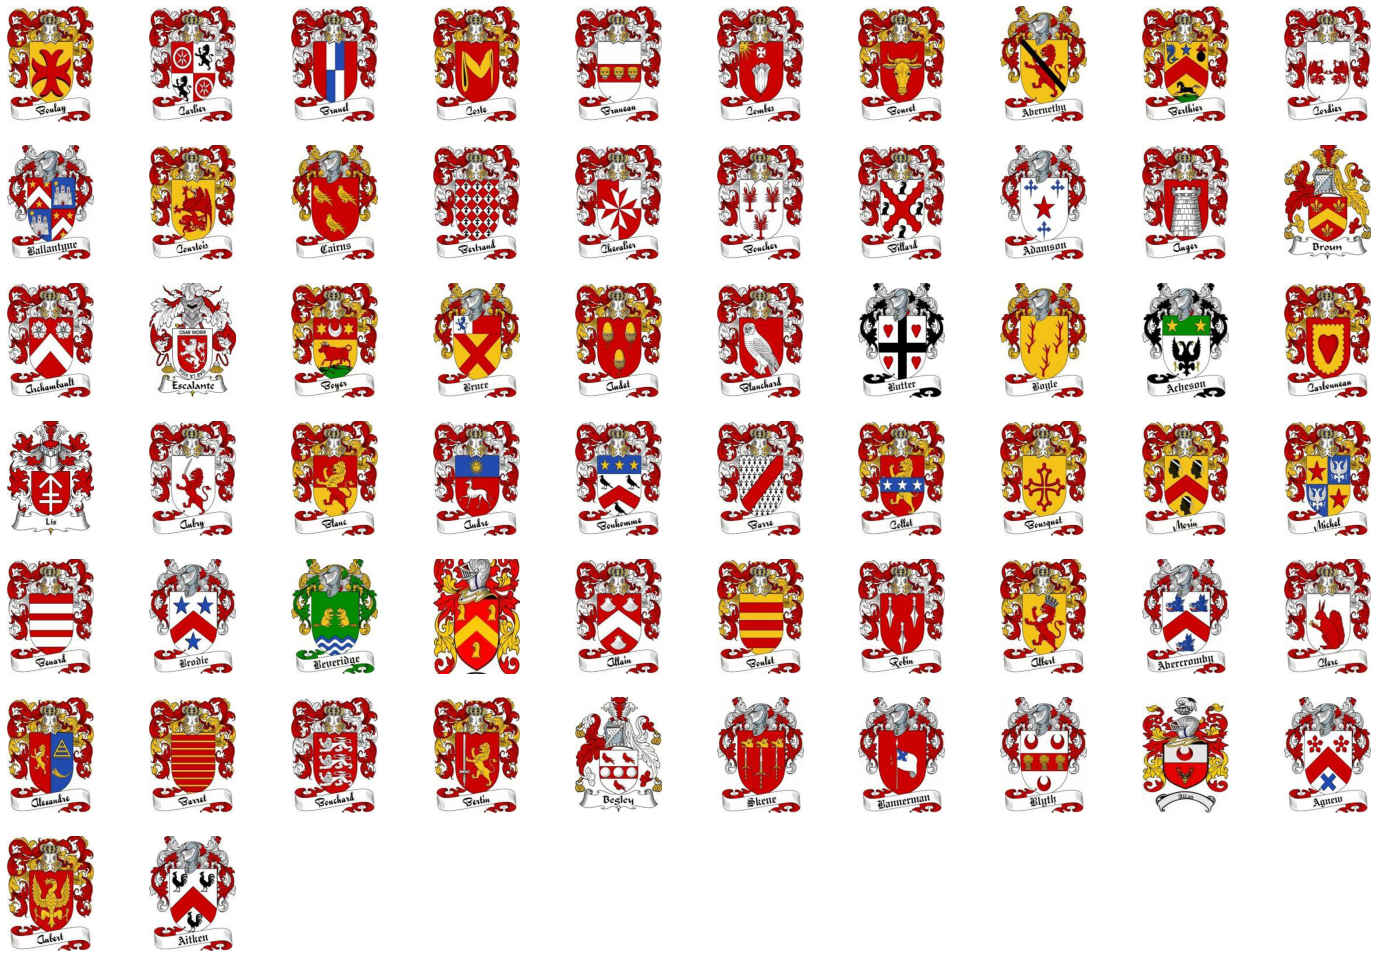

In [12]:
view_cluster(2)

 Saving these groupings to a new folder in local machine

In [ ]:
for folder_name, images in groups.items():
        dest_path = f"C:/Users/Ray/OneDrive/Desktop/Capstone Project/GAN_images/Crest_Clusters/{folder_name}"
        os.mkdir(dest_path)
        for image in images:
            os.rename(f"C:/Users/Ray/OneDrive/Desktop/Capstone Project/GAN_images/Crests_Raw/crest_images_copy/{image}", f"{dest_path}/{image}")